In [61]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from codac import Interval, IntervalVector, CtcDist, Function,CtcFunction
from collections import deque
import networkx as nx
from scipy.optimize import minimize

In [62]:
f= open("graph_02.txt", mode="r")
li = []
for line in f:
    li.append(line)

In [63]:
f.close()

In [64]:
dico_constrains = {}
n= 63
dico_interval = {}
dico_interval_origin = {}
for elem in li:
    i = int(elem[6:8].split(" ")[-1])-1
    j = int(elem[16:18].split(" ")[-1])-1
    mini = float(elem[21:42])
    maxi = float(elem[45:-1])
    dico_constrains[(i,j)] = (maxi + mini)/2
    dico_interval[(i,j)] = [mini, maxi]
    dico_interval_origin[(i,j)] = [mini, maxi]
    #dico_interval[(j,i)] = [mini, maxi]

In [5]:
G = nx.Graph()
G.add_nodes_from([i for i in range(63)])
for (i,j), (mini, maxi) in dico_interval.items():
    G.add_edges_from([(i,j,{"mini":mini, "maxi":maxi})])

In [6]:
eps = 1e-8
link = dict(nx.all_pairs_dijkstra(G))
for i in range(n-1):
    pairs = link[i][1]
    for j in range(i+1,n):
        if ((i,j) not in dico_interval.keys()) and i!=j:
            path = pairs[j]
            maxi = 0
            for k in range(len(path)-1):
                u = path[k]
                v = path[k+1]
                maxi += G.get_edge_data(u,v)["maxi"]
            G.add_edges_from([(i,j,{"mini":eps, "maxi":maxi})])
            dico_interval[(i,j)] = [eps,maxi]
            


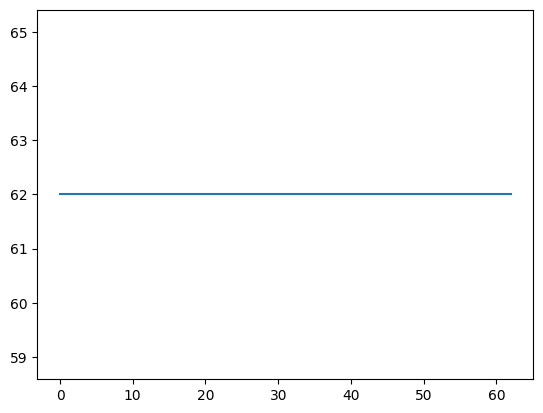

In [7]:
n_contraintes = np.zeros(63)
for (i,j) in dico_interval.keys():
    n_contraintes[i] +=1
    n_contraintes[j] +=1
plt.plot(n_contraintes)

# Evolution

In [ ]:
def c_in(X,dico_interval):
    count = 0
    for key, value in dico_interval.items():
        i,j = key
        mini,maxi = value
        if (np.linalg.norm(X[i]-X[j]) > mini and np.linalg.norm(X[i]-X[j]) < maxi):
            count += 1
    return count

In [ ]:
def error(X,dico_interval):
    li = []
    for key, value in dico_interval.items():
        i,j = key
        mini,maxi = value
        li.append([np.linalg.norm(X[i]-X[j]), mini, maxi])
    return li

In [ ]:
def cost_indiv(X, dico_interval):
    cout = 0
    for key, value in dico_interval.items():
        i,j = key
        mini, maxi = value
        mean = (maxi+mini)/2
        dist = np.linalg.norm(X[i]-X[j])
        cout += np.max([(maxi**2 -dist**2)/maxi**2, (dist**2 - mini**2)/mini**2, 0])
        #cout += (dist**2  - mean**2)**2 
    return cout

In [ ]:
def cost(X,dico_interval):
    n = X.shape[0]
    li_cost = np.zeros(n)
    for i in range(n):
        li_cost[i] = cost_indiv(X[i],dico_interval)
    return li_cost

In [ ]:
def select(X,cost, frac = 0.7):
    ordering = np.argsort(cost)
    n = int(frac*ordering.shape[0])
    X_child = X[ordering[:n]]
    return X_child


In [ ]:
def variation(X,i):
    atoms = np.random.choice([i for i in range(63)],size=X.shape[0], replace=True)
    X[:,atoms,:] += np.random.normal(loc=0, scale=0.02,size=(X.shape[0],3))
    return X


In [ ]:
def remplacement(X,X_child,cost_X, cost_child):
    n = X.shape[0]
    cost_tot = np.concatenate([cost_X,cost_child])
    ordering = np.argsort(cost_tot)[:n]
    X_tot = np.concatenate([X, X_child])
    return X_tot[ordering], cost_tot[ordering]


In [ ]:
X = np.random.normal(loc=0, scale= 10,size=(200,63,3))
cost_X = cost(X, dico_interval)
mean = np.mean(cost_X)
N_iter = 1000
n = 0
while n<N_iter:
    if (n%10 == 0):
        print(n)
    X_child =  select(X, cost_X, frac=0.7)
    X_child = variation(X_child,i)
    cost_child = cost(X_child, dico_interval)
    X, cost_X = remplacement(X,X_child, cost_X,cost_child)
    n += 1


In [ ]:
c_in(X,dico_interval)

In [ ]:
cost_X[0]

In [ ]:
li = error(X[0], dico_interval)

# SPE

In [39]:
def cost_indiv(X, dico_interval):
    cout = 0
    for key, value in dico_interval.items():
        i,j = key
        mini, maxi = value
        dist = np.linalg.norm(X[i]-X[j])
        cout += np.max([(maxi**2 -dist**2)/maxi**2, (dist**2 - mini**2)/mini**2, 0])
    return cout

In [40]:
def has_terminated(X, dico_interval):
    for key, value in dico_interval.items():
        i,j = key
        mini, maxi = value
        dist = np.linalg.norm(X[i]-X[j])
        if dist>maxi or dist<mini:
            return False
    return True

In [49]:
def choose_constrain(dico_interval):
    index = np.random.choice([i for i in range(len(list(dico_interval.keys())))])
    return list(dico_interval.keys())[index]

In [50]:
choose_constrain(dico_interval)

(45, 48)

In [56]:
def iter(X,dico_interval, l):
    (i,j) = choose_constrain(dico_interval)
    low, up = dico_interval[(i,j)]
    dist = np.linalg.norm(X[i] - X[j])
    if dist<low or dist>up:
        dist_low = np.abs(dist - low)
        dist_up = np.abs(dist - up)
        if dist_low < dist_up:
            t = low
        else:
            t = up
        X[j] = X[j] + l*(t-dist)/(2*(dist + eps))* (X[j] - X[i])
        X[i] = X[i] + l*(t-dist)/(2*(dist + eps))* (X[i] - X[j])
    return X
        

In [57]:
def cycle(X,dico_interval,l,S):
    for _ in range(S):
        X = iter(X,dico_interval,l)
    return X

In [58]:
def update_param(l,delta):
    return l*delta

In [60]:
X = np.random.uniform(low=-20,high=20, size=(63,3))
eps = 1e-10
l = 1e-2
n_cycle = 0
while not has_terminated(X,dico_interval) and n_cycle<50:
    print(n_cycle)
    X = cycle(X, dico_interval,l,50*236)
    l = update_param(l,0.9/50)
    n_cycle+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [63]:
cost_indiv(X,dico_interval)

1103.9897755208065

# Codac

In [ ]:
M = 63

In [ ]:
help(Interval)

In [29]:
li_f = []
li_interval = []
li_ctc = []
for (l,k), [low,up] in dico_interval.items():
    i = 3*l 
    j = 3*k 
    f = Function(f"X[{n*3}]", f"sqrt((X[{i}]-X[{j}])^2+(X[{i}+1]-X[{j}+1])^2+(X[{i}+2]-X[{j}+2])^2)")
    li_f.append(f)
    contractor = CtcFunction(f, Interval(low,up))
    li_ctc.append(contractor)
    li_interval.append((low, up))


def contract(x,li_ctc):
    for ctc in li_ctc:
        ctc.contract(x)
    
def empty(X):
    for i in range(3):
        if X[i].is_empty():
            return True
    return False
def C_in(X, li_f, li_constrains):
    if (empty(X)):
        return False
    for i in range(len(li_f)):
        eval = li_f[i].eval(X)
        low, up = li_constrains[i]
        if ((eval.lb() < low) or (eval.ub()>up)):
            #in_it = False
            return False
    return True
def C_out(X,li_f, li_constrains):
    out_it = False
    for i in range(len(li_f)):
        eval = li_f[i].eval(X)
        low, up = li_constrains[i]
        if ((eval.lb()> up) or (eval.ub() < low)):
            out_it = True
    return out_it
def get_largest(X):
    max_index = 0
    for i in range(n*3):
        if (X[max_index].diam() < X[i].diam()):
            max_index = i
    return max_index
def mean(vector):
    vec = []
    for i in range(3):
        vec.append((vector[i][0]+vector[i][1])/2)
    return np.array(vec).reshape(1,3)

In [54]:
tau = 0.5
stack = [IntervalVector(n*3,(-20,20))]
stack[0][0] = Interval(0,0)
stack[0][1] = Interval(0,0)
stack[0][2] = Interval(0,0)
stack[0][4] = Interval(0,0)
stack[0][5] = Interval(0,0)
stack[0][6] = Interval(0,0)

stack_acc = []
stack_rej = []
stack_unc = []
sol = 0
count = 0
while len(stack) !=0 and (not sol):
    x = stack.pop()
    count +=1
    contract(x, li_ctc)
    if not empty(x):
        if (C_in(x,li_f, li_interval)):
            sol = True
            stack_acc.append(x)
        else:
            if C_out(x, li_f, li_interval):
                stack_rej.append(x)
            else:
                larger_index = get_largest(x)
                if x[larger_index].diam() > tau:
                    X_left, X_right  = x.bisect(larger_index)
                    if not (empty(X_left)):
                        stack.append(X_left)
                    if not (empty(X_right)):
                        stack.append(X_right)
                else:
                    stack_unc.append(x)
    
    


    
        

KeyboardInterrupt: 

In [59]:
len(stack_acc)

0

In [57]:
count

3792

In [ ]:
solution = stack_acc.pop()

# Lsbuild

## Clique

In [65]:
G = nx.Graph()

In [66]:
G.add_nodes_from([i for i in range(63)])

In [67]:
for (i,j), (mini, maxi) in dico_interval.items():
    G.add_edges_from([(i,j,{"mini":mini, "maxi":maxi})])

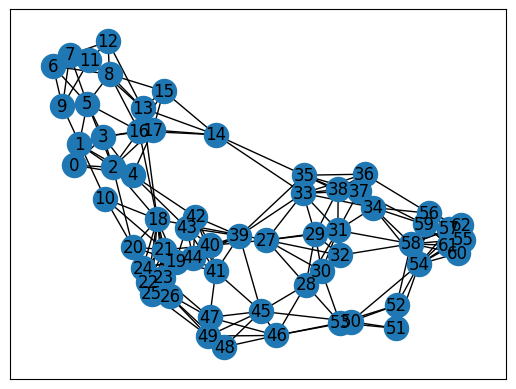

In [87]:
nx.draw_networkx(G, pos= nx.spring_layout(G))

In [69]:
cliques = nx.find_cliques(G)

In [70]:
for clique in cliques:
    print(clique)

[0, 1, 2, 3, 4]
[1, 5, 2, 3]
[3, 2, 16, 17]
[3, 2, 16, 5]
[3, 2, 17, 4]
[4, 42, 43]
[5, 8, 16]
[5, 8, 6, 7]
[6, 9, 7]
[7, 11, 9]
[7, 11, 12]
[7, 12, 8]
[8, 13, 16, 15]
[8, 13, 12]
[9, 10]
[11, 12, 13]
[14, 33, 35]
[14, 13, 16, 17, 15]
[18, 16, 2]
[18, 16, 13]
[18, 27, 21]
[18, 20, 2]
[18, 20, 21, 10]
[18, 20, 21, 19, 22, 24, 25, 26, 23]
[28, 45, 46]
[28, 46, 53]
[28, 30, 32, 27, 29, 31]
[28, 30, 53]
[29, 31, 27, 33]
[29, 31, 38, 33]
[31, 32, 58]
[31, 33, 34, 37, 38]
[31, 58, 34]
[33, 35, 34, 36, 37, 38]
[33, 35, 39]
[34, 56, 58, 59, 54]
[34, 56, 36]
[34, 59, 37]
[39, 41, 40, 43, 42, 44]
[39, 41, 40, 43, 19]
[39, 41, 45]
[41, 47, 45]
[44, 23, 24]
[45, 46, 50]
[45, 46, 47, 48, 49]
[46, 53, 50]
[47, 22, 23]
[48, 26, 49]
[49, 25, 26]
[50, 51, 52, 53]
[50, 51, 52, 54]
[52, 58, 54]
[54, 55, 56, 57, 58, 59, 60, 61, 62]


In [9]:
maxi_clique = max(nx.find_cliques(G), key=len)

In [73]:
maxi_clique = [54, 55, 56, 57, 58, 59, 60, 61, 62]

In [74]:
sub = nx.Graph()
for node in maxi_clique:
    sub.add_node(node)

In [75]:
for (i,j), (mini, maxi) in dico_interval.items():
    if i in maxi_clique and j in maxi_clique:
        sub.add_edges_from([(i,j,{"mini":mini, "maxi":maxi})])

In [88]:
len(list(sub.edges))

36

In [77]:
def get_edm(nodes,t, graph):
    n = len(nodes)
    matrix = np.zeros((n,n))
    for k in range(n-1):
        for l in range(k+1,n):
            i = nodes[k]
            j = nodes[l]
            low = graph.get_edge_data(i,j)["mini"]
            up = graph.get_edge_data(i,j)["maxi"]
            matrix[k,l] = (1-t[k,l])*low + t[k,l]*up
            matrix[l,k] = (1-t[k,l])*low + t[k,l]*up
    return matrix

In [78]:
def get_x(EDM):
    U, S, Vh = np.linalg.svd(EDM)
    x = U[:,:3]
    return x

In [79]:
lamb = 1
tau = 0.1

def theta(x,i,j,c):
    return (lamb**2 *(c-np.sqrt(np.linalg.norm(x[3*i:3*(i+1)]-x[3*j:3*(j+1)])**2 + tau**2))**2 + tau**2)
def phi(x,i,j, low,up):
    value = lamb*(low - up) + theta(x,i,j,low) + theta(x,i,j,up)
    return value
def cost(x,dico_interval):
    cost_value = 0
    for (i,j) in dico_interval.keys():
            low, up = dico_interval[(i,j)]
            cost_value += phi(x,i,j,low,up)
    return cost_value


In [80]:
def get_n_error(X,nodes, graph):
    n = len(nodes)
    count = 0
    relative_error = []
    count_tot = 0
    for k in range(n-1):
        for l in range(k+1,n):
            i = nodes[k]
            j = nodes[l]
            count_tot += 1
            low = graph.get_edge_data(i,j)["mini"]
            up = graph.get_edge_data(i,j)["maxi"]
            dist = np.linalg.norm(X[k]-X[l])
            print(f"edge: ({i,j}")
            print(dist)
            print(f"low : {low}    up : {up}")
            print()
            if (dist>up or dist < low):
                count += 1
                relative_error.append(np.min([np.abs(dist-low)/low,np.abs(dist-up)/up]))

    return

In [81]:
def c_in_intermediate(X,nodes,graph):
    n = len(nodes)
    count = 0
    relative_error = []
    count_tot = 0
    for k in range(n-1):
        for l in range(k+1,n):
            i = nodes[k]
            j = nodes[l]
            count_tot += 1
            low = graph.get_edge_data(i,j)["mini"]
            up = graph.get_edge_data(i,j)["maxi"]
            dist = np.linalg.norm(X[k]-X[l])
            if (dist>up or dist < low):
                count += 1
                relative_error.append(np.min([np.abs(dist-low)/low,np.abs(dist-up)/up]))
    return count

In [82]:
def place_relative_atoms(clique,dico_interval, t=0.7):
    atoms = list(clique.nodes)
    n = len(atoms)
    ponderation = np.ones((n,n))*t
    D = get_edm(list(clique.nodes),ponderation,clique)
    x = get_x(D)
    print("before opti")
    res = minimize(cost,x.flatten(),args=(dico_interval),method='BFGS',options={"maxiter" : 100})
    print("after")
    X = res.x.reshape(n,3)
    dico_index_to_X = {}
    dico_X_to_index = {}
    count = 0
    for node in list(clique.nodes):
        dico_index_to_X[node] = count
        count += 1
    count = 0
    for node in list(clique.nodes):
        dico_X_to_index[count] = node
    count += 1 
    return X, dico_X_to_index, dico_index_to_X

In [91]:
list(sub.nodes)

[54, 55, 56, 57, 58, 59, 60, 61, 62]

In [85]:
X, dico_X_to_index, dico_index_to_X = place_relative_atoms(sub,dico_interval)

before opti


ValueError: operands could not be broadcast together with shapes (3,) (0,) 

In [21]:
def verif(X,dico_interval):
    n = X.shape[0]
    count = 0
    for (i,j), (low,up) in dico_interval.items():
        if i<n and j<n:
            dist = np.linalg.norm(X[i] - X[j])
            if low<dist<up:
                count +=1
            """print(f"edge: ({i,j}")
            print(dist)
            print(f"low : {low}    up : {up}")
            print()"""
    return count

In [23]:
verif(X,dico_interval_origin)

128

In [20]:
def best_node(nodes_base,node_to_choose, graph):
    counter = [[] for _ in range(len(node_to_choose))]
    for (i,j) in graph.edges:
        if ((i in nodes_base) and (j not in nodes_base)):
            counter[j].append(i)
        if ((j in nodes_base) and (i not in nodes_base)):
            counter[i].append(j)
    for i in range(len(counter)):
        if (len(counter[i])>=3):
            return i, counter[i]


In [21]:
node, node_base_connected = best_node(list(sub.nodes), list(G.nodes), G)

In [22]:
X

array([[ 0.92379823, -3.5731522 , -0.09978916],
       [ 1.02014942, -1.09452151,  0.45208743],
       [ 0.5266358 , -1.48538446, -1.18061632],
       [-0.94895303, -2.13476559,  1.38241174],
       [-1.2133437 ,  0.10901311, -1.18948256],
       [ 0.4240286 ,  1.58868486,  0.84494465],
       [-1.3290413 ,  2.28799029, -1.21421349],
       [-1.01081181,  4.10579787,  0.04746002],
       [-1.35792877,  0.11808317,  0.55467378]])

## Compute 10th atom

In [24]:
def get_f_ctc(node_base_connected, node_to_solve, graph):
    li_ctc = []
    li_constrains = []
    li_f = []
    for atom in node_base_connected:
        low = graph.get_edge_data(node_to_solve,atom)["mini"]
        up = graph.get_edge_data(node_to_solve,atom)["maxi"]
        li_constrains.append([low,up])
        center = X[dico_index_to_X[atom]]
        f = Function("x[3]", f"sqrt(sqr(x[0]-{center[0]})+sqr(x[1]-{center[1]})+sqr(x[2]-{center[2]}))")
        li_f.append(f)
        contractor = CtcFunction(f, Interval(low,up))
        li_ctc.append(contractor)
    return li_ctc,li_f, li_constrains


In [25]:
li_ctc, li_f, li_constrains = get_f_ctc(node_base_connected, node, G)

In [26]:
def contract(x,li_ctc):
    for ctc in li_ctc:
        ctc.contract(x)
    

In [27]:
def empty(X):
    for i in range(3):
        if X[i].is_empty():
            return True
    return False

In [28]:
def C_in(X, li_f, li_constrains):
    if (empty(X)):
        return False
    for i in range(len(li_f)):
        eval = li_f[i].eval(X)
        low, up = li_constrains[i]
        if ((eval.lb() < low) or (eval.ub()>up)):
            #in_it = False
            return False
    return True

In [29]:
def C_out(X,li_f, li_constrains):
    out_it = False
    for i in range(len(li_f)):
        eval = li_f[i].eval(X)
        low, up = li_constrains[i]
        if ((eval.lb()> up) or (eval.ub() < low)):
            print(i)
            out_it = True
    return out_it

In [30]:
def get_largest(X):
    max_index = 0
    for i in range(3):
        if (X[max_index].diam() < X[i].diam()):
            max_index = i
    return max_index

In [31]:
tau = 0.000001
stack = [IntervalVector([[-10,10] for _ in range(3)])]
stack_acc = []
stack_rej = []
stack_unc = []
sol = False
count = 0
while len(stack) !=0 and (not sol):
    x = stack.pop()
    count +=1
    contract(x, li_ctc)
    if not empty(x):
        if (C_in(x,li_f, li_constrains)):
            sol = True
            print("sol")
            stack_acc.append(x)
        else:
            if C_out(x, li_f, li_constrains):
                stack_rej.append(x)
            else:
                larger_index = get_largest(x)
                if x[larger_index].diam() > tau:
                    X_left, X_right  = x.bisect(larger_index)
                    if not (empty(X_left)):
                        stack.append(X_left)
                    if not (empty(X_right)):
                        stack.append(X_right)
                else:
                    stack_unc.append(x)

0
0
0
0
0
sol


In [40]:
def mean(vector):
    vec = []
    for i in range(3):
        vec.append((vector[i][0]+vector[i][1])/2)
    return np.array(vec).reshape(1,3)


In [42]:
X_10 = mean(stack_acc[0])

In [43]:
X_10

array([[ 2.80121905, -1.68063212, -2.12347416]])

In [47]:
X = np.concatenate([X,X_10])

In [48]:
dico_index_to_X[10] = 10
dico_X_to_index[10] = 10

In [49]:
nodes_base = list(sub.nodes)
nodes_base.append(10)

In [50]:
node, node_base_connected = best_node(nodes_base, list(G.nodes), G)

TypeError: cannot unpack non-iterable NoneType object

In [52]:
counter = [[] for _ in range(63)]
for (i,j) in G.edges:
    if ((i in nodes_base) and (j not in nodes_base)):
        counter[j].append(i)
    if ((j in nodes_base) and (i not in nodes_base)):
        counter[i].append(j)


In [ ]:
counter

In [34]:
count = 0
for node_base in node_base_connected:
    bounds = li_f[count].eval(stack_acc[0])
    print(f"Low : {bounds.lb()}    Up : {bounds.ub()}")
    print(f"Needed low : {G.get_edge_data(node,node_base)['mini']}    Needed Up : {G.get_edge_data(node,node_base)['maxi']}")
    print()
    count +=1

Low : 3.3468848592262983    Up : 3.346886033314764
Needed low : 3.280604499173894    Needed Up : 3.346886033315147

Low : 3.185788515607867    Up : 3.185789688563983
Needed low : 3.185788056352778    Needed Up : 3.250153913278571

Low : 2.469985694327776    Up : 2.469986587840734
Needed low : 2.469650991537058    Needed Up : 2.519547971363112



## N cliques

In [26]:
G_prime = G.copy()

In [56]:
for noeud in list(sub.nodes):
    G_prime.remove_node(noeud)

In [65]:
cliques = nx.find_cliques(G)

In [ ]:
def already_seen(clique, cliques_tested):
    for i in range(len(cliques_tested)):
        if cliques_tested[i] in clique:

In [67]:
cliques = nx.find_cliques(G)
X_tot = []
li_index_to_X_tot = []
li_X_to_index_tot = []
errors = []
cliques_testes = []
for clique in cliques:
    if (len(clique)>3):
        sub = nx.Graph()
        for node in clique:
            sub.add_node(node)
        for (i,j), (mini, maxi) in dico_interval.items():
            if i in clique and j in clique:
                sub.add_edges_from([(i,j,{"mini":mini, "maxi":maxi})])
        X, dico_X_to_index, dico_index_to_X = place_relative_atoms(sub)
        errors.append(c_in_intermediate(X,list(sub.nodes),sub))
        X_tot.append(X)
        li_index_to_X_tot.append(dico_index_to_X)
        li_X_to_index_tot.append(dico_X_to_index)
        errors.append(c_in_intermediate(X,list(sub.nodes),sub))
    

In [69]:
def post_treatment(X_tot, li_X_to_index_tot, li_index_to_X_tot):
    n = len(X_tot)
    cliques_seen = []

True

In [62]:
maxi_clique = max(nx.find_cliques(G_prime), key=len)

In [63]:
maxi_clique

[54, 58, 56, 59, 55, 57, 60, 61, 62]

# Construction

In [155]:
def get_f_ctc(X, dico_interval, atom):
    li_ctc = []
    li_constrains = []
    li_f = []
    for ((i,j), (low,up)) in dico_interval.items():
        if j == atom and i!=j:
            #low1 = low*0.6+0.4*up
            #up = low*0.4+0.6*up
            #low = low1
            li_constrains.append([low,up])

            center = X[i]
            f = Function("x[3]", f"sqrt(sqr(x[0]-{center[0]})+sqr(x[1]-{center[1]})+sqr(x[2]-{center[2]}))")
            li_f.append(f)
            contractor = CtcFunction(f, Interval(low,up))
            li_ctc.append(contractor)
    
    return li_ctc, li_f, li_constrains

def contract(x,li_ctc):
    for ctc in li_ctc:
        ctc.contract(x)
    
def empty(X):
    for i in range(3):
        if X[i].is_empty():
            return True
    return False
def C_in(X, li_f, li_constrains):
    if (empty(X)):
        return False
    for i in range(len(li_f)):
        eval = li_f[i].eval(X)
        low, up = li_constrains[i]
        if ((eval.lb() < low) or (eval.ub()>up)):
            #in_it = False
            return False
    return True
def C_out(X,li_f, li_constrains):
    out_it = False
    for i in range(len(li_f)):
        eval = li_f[i].eval(X)
        low, up = li_constrains[i]
        if ((eval.lb()> up) or (eval.ub() < low)):
            out_it = True
    return out_it
def get_largest(X):
    max_index = 0
    for i in range(3):
        if (X[max_index].diam() < X[i].diam()):
            max_index = i
    if (X[0].diam() == X[1].diam() and X[1].diam() == X[2].diam()):
        return np.random.randint(3)
    return max_index
def mean(vector):
    vec = []
    for i in range(3):
        vec.append((vector[i][0]+vector[i][1])/2)
    return np.array(vec).reshape(1,3)


In [156]:
def add_atom(X, dico_interval, atom):
    tau = 0.0000000001
    stack = [IntervalVector([[-20,20] for _ in range(3)])]
    li_ctc, li_f, li_constrains = get_f_ctc(X, dico_interval, atom)
    print(len(li_ctc))
    stack_acc = []
    stack_rej = []
    stack_unc = []
    sol = 0
    count = 0
    while len(stack) !=0 and (not sol):
        x = stack.pop()
        count +=1
        contract(x, li_ctc)
        if not empty(x):
            if (C_in(x,li_f, li_constrains)):
                sol = True
                stack_acc.append(x)
            else:
                if C_out(x, li_f, li_constrains):
                    stack_rej.append(x)
                else:
                    larger_index = get_largest(x)
                    if x[larger_index].diam() > tau:
                        X_left, X_right  = x.bisect(larger_index)
                        if not (empty(X_left)):
                            stack.append(X_left)
                        if not (empty(X_right)):
                            stack.append(X_right)
                    else:
                        stack_unc.append(x)
    if (len(stack_acc) != 0):
        pos = mean(stack_acc[0])
    new_X = np.concatenate([X,pos])
    return new_X
    

In [167]:
def get_pos(X, dico_interval, atom):
    tau = 0.0000000001
    stack = [IntervalVector([[-20,20] for _ in range(3)])]
    li_ctc, li_f, li_constrains = get_f_ctc(X, dico_interval, atom)
    stack_acc = []
    stack_rej = []
    stack_unc = []
    sol = 0
    count = 0
    while len(stack) !=0 and (not sol):
        x = stack.pop()
        count +=1
        contract(x, li_ctc)
        if not empty(x):
            if (C_in(x,li_f, li_constrains)):
                sol = True
                stack_acc.append(x)
            else:
                if C_out(x, li_f, li_constrains):
                    stack_rej.append(x)
                else:
                    larger_index = get_largest(x)
                    if x[larger_index].diam() > tau:
                        X_left, X_right  = x.bisect(larger_index)
                        if not (empty(X_left)):
                            stack.append(X_left)
                        if not (empty(X_right)):
                            stack.append(X_right)
                    else:
                        stack_unc.append(x)
    if (len(stack_acc) != 0):
        pos = stack_acc[0]
    else:
        pos = [0,0,0]
    return pos

In [175]:
dico_tot = []
count = 0
def construct(i,n,X,dico_interval):
    
    if i>n:
        return X
    else:
        pos = get_pos(X,dico_interval,i)
        if pos!=[0,0,0]:
            print(len(dico_tot))
            x_moins = np.array([pos[0][0], pos[1][0], pos[2][0]]).reshape((1,3))
            x_plus = np.array([pos[0][1], pos[1][1], pos[2][1]]).reshape((1,3))
            X_moins = np.concatenate([X, x_moins])
            X_plus = np.concatenate([X,x_plus])
            dico_tot.append(construct(i+1,n,X_moins,dico_interval))
            dico_tot.append(construct(i+1,n,X_plus,dico_interval))
        else:
            return X
X = np.zeros((1,3))
construct(1,n,X,dico_interval )

0
0
0
0
0
0
0
3
7
7
10
15
15
15
18
22
22
22
22
22
22
25
29
29
32
37
37
37
40
44
44
47
53
53
53
53
56
60
60
63
68
68
68
71
75
75
78
85
85
85
85
85
88
92
92
95
100
100
100
103
107
107
110
116
116
116
116
119
123
123
126
131
131
131
134
138
138
141
151
151
151
151
151
151
151
151
154
158
158
161
166
166
166
169
173
173
176
182
182
182
182
185
189
189
192
197
197
197
200
204
204
207
214
214
214
214
214
217
221
221
224
229
229
229
232
236
236
239
245
245
245
245
248
252
252
255
260
260
260
263
267
267
270
278
278
281
286
286
286
286
286
286
286
289
293
293
296
301
301
301
304
308
308
311
317
317
317
317
320
324
324
327
332
332
332
335
339
339
342
349
349
349
349
349
352
356
356
359
364
364
364
367
371
371
374
380
380
380
380
383
387
387
390
395
395
395
398
402
402
405
413
413
416
423
423
423
423
423
423
423
423
423
426
430
430
433
438
438
438
441
445
445
448
454
454
454
454
457
461
461
464
469
469
469
472
476
476
479
486
486
486
486
486
489
493
493
496
501
501
501
504
508
508
511
517
517
51

In [179]:
n_max = 1
elem_max = []
for elem in dico_tot:
    if elem is not None and len(elem)>n_max:
        elem_max = elem
        n_max = len(elem)

In [182]:
elem_max

array([[ 0.        ,  0.        ,  0.        ],
       [ 1.58458354,  1.58518573,  1.58458352],
       [ 2.10139974,  0.11953618,  4.02279336],
       [ 3.24804356,  0.30678786,  2.73413321],
       [ 4.78000316, -1.47794656,  2.86233139],
       [ 1.34383726,  2.93823523,  3.3651353 ],
       [ 3.00889981,  4.6032978 ,  5.03083065],
       [ 3.82327194,  5.42014642,  2.84926642],
       [ 2.91407978,  3.9353226 ,  1.05098006],
       [ 4.70176196,  6.30311374,  5.27865928],
       [ 5.50887084,  4.36246266,  7.17310359],
       [ 6.51436363,  5.95017722,  3.48340741]])

In [72]:
#X = np.random.normal(loc = 0, scale=20, size=(63,3))
X = np.zeros((,3))
X[1] = [dico_constrains[(0,1)],0,0]
X[2] = [0,dico_constrains[(0,2)],0]
#X[3] = [0,0,dico_constrains[(0,3)]]



In [73]:
X

array([[0.        , 0.        , 0.        ],
       [2.71784866, 0.        , 0.        ],
       [0.        , 4.49537026, 0.        ]])

In [137]:
count = 1
X = np.zeros((1,3))
while count!=15:
    print(count)
    X = add_atom(X, dico_interval, count)
    count += 1

1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12


UnboundLocalError: local variable 'pos' referenced before assignment

In [139]:
X.shape

(12, 3)

In [140]:
for i in range(12):
    for j in range(12):
        for k in range(12):
            if np.linalg.norm(X[i]-X[j]) > np.linalg.norm(X[i]-X[k]) + np.linalg.norm(X[k]-X[j]):
                print("error")

In [92]:
X_5_8 = np.array([[-0.5086419 , -0.04529048, -1.89655235],
       [-0.50091488,  2.0554787 ,  0.15775394],
       [-0.49707916, -2.0204531 ,  0.16403237],
       [-0.4921365 ,  0.00635664,  1.61221973]])

In [ ]:
X_tot = np.concatenate([X,X_5_8])

In [78]:
count = 5
X = np.zeros((5,3))
while count!=9:
    print(count)
    X = add_atom(X, dico_interval, count)
    count += 1

5
3


UnboundLocalError: local variable 'pos' referenced before assignment

In [67]:
np.linalg.norm(X[1])

2.7205665736483455

In [105]:
def verif(X,dico_interval):
    n = X.shape[0]
    count = 0
    for (i,j), (low,up) in dico_interval.items():
        if i<n and j<n:
            dist = np.linalg.norm(X[i] - X[j])
            print(f"edge: ({i,j}")
            print(dist)
            print(f"low : {low}    up : {up}")
            print()
    return count

In [111]:
def verif_tot(X, dico_interval):
    for (i,j), (low,up) in dico_interval.items():
        dist = np.linalg.norm(X[i] - X[j])
        if dist<low or dist >up:
            return False
    return True

In [112]:
verif_tot(X,dico_interval)

False

In [128]:
np.linalg.norm(X[0] - X[1])

2.7161861812419787

In [84]:
X0 = np.array([2.83455656e+00 ,  6.36186041e-01 ,  3.63035087e+00 ])
X1 = np.array([6.89690506e-01 , -4.68265409e-01 ,  2.38392374e+00])
np.linalg.norm(X0 - X1)

2.7154822749207317

In [129]:
X 

array([[ 0.55787626,  3.02003749,  0.19846142],
       [-1.30423651,  1.31719859, -0.8067963 ],
       [-1.6210181 , -0.78209289,  1.19615428],
       [-0.71340402, -0.96693982, -0.28869732],
       [ 0.86540609, -2.67338861, -0.04022001],
       [-0.51897231,  2.01584711,  1.16923965],
       [ 1.13853775,  3.6727275 ,  2.82612003],
       [-1.06257858,  4.48145958,  3.6341082 ],
       [-2.85191609,  2.94703924,  2.72455013],
       [ 1.35081799,  5.36385337,  4.51567046],
       [ 2.97623767,  6.98989076,  6.14109012],
       [-0.73378358,  6.44859615,  5.60124475]])

In [87]:
X + np.array(X0)

array([[2.83455656, 0.63618604, 3.63035087],
       [4.4113534 , 2.21298286, 5.20774694],
       [2.95296691, 4.69363621, 5.61378847],
       [3.08799176, 3.42792869, 6.80583393],
       [1.32855709, 3.57049243, 8.3230864 ],
       [5.78924311, 3.95617846, 4.93912691],
       [7.44675317, 5.61305887, 6.59600727],
       [5.24563684, 6.42179094, 7.40399546],
       [3.45629934, 4.8873706 , 6.49443739],
       [7.65903342, 7.30418474, 8.2855577 ],
       [9.28445307, 8.92960443, 9.91159509],
       [5.57443185, 8.3889275 , 9.371132  ]])

In [134]:
X8 = np.array([  7.06760517e-01,  -4.71016652e+00 , -1.34681783e+00])
X9 = np.array([ -1.49827588e+00 , -4.08228545e+00,  -3.37522343e-01])
X12 = np.array([ -1.04372973e+00 , -3.02951353e+00 ,  3.31519175e-02])
X13 = np.array([  5.43530260e-01 , -1.51619354e+00 , -3.06569111e-01])
print(np.linalg.norm(X8-X13))
print(np.linalg.norm(X9-X13))
print(np.linalg.norm(X12-X13))

      


3.363067782717367
3.2794447863137433
2.2192210446896676


In [27]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

IndexError: list index out of range

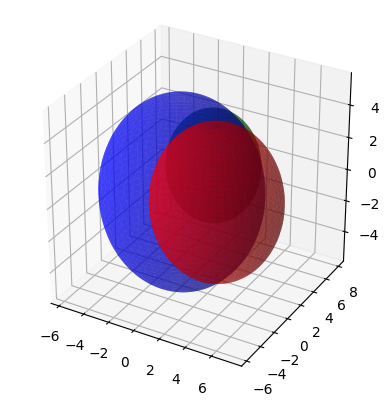

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect("equal")
color = ["b","r","g"]
count = 0
for i in [0,1,2,3]:
    center = X[i]
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    radius = np.mean(dico_interval[(i,4)])
    x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = center[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color=color[count], alpha=0.5)
    count += 1
plt.show()

In [63]:
for (i,j),(low,up) in dico_interval.items():
    if j==12:
        print(i)

7
8
11


# APA

In [86]:
G = nx.Graph()
G.add_nodes_from([i for i in range(n)])
for (i,j), (mini, maxi) in dico_interval.items():
    G.add_edges_from([(i,j,{"mini":mini, "maxi":maxi})])
eps = 1e-8
link = dict(nx.all_pairs_dijkstra(G))
for i in range(n-1):
    pairs = link[i][1]
    for j in range(i+1,n):
        if ((i,j) not in dico_interval.keys()) and i!=j:
            path = pairs[j]
            maxi = 0
            for k in range(len(path)-1):
                u = path[k]
                v = path[k+1]
                maxi += G.get_edge_data(u,v)["maxi"]
            G.add_edges_from([(i,j,{"mini":eps, "maxi":maxi})])
            dico_interval[(i,j)] = [eps,maxi]
            

for k in range(n):
    for i in range(n-1):
        for j in range(i+1,n):
            if i!=j and j!=k and i!=k:
                low = G.get_edge_data(i,j)["mini"]
                up = G.get_edge_data(i,j)["maxi"]
                if up > G.get_edge_data(i,k)["maxi"] + G.get_edge_data(k,j)["maxi"]:
                    up = G.get_edge_data(i,k)["maxi"] + G.get_edge_data(k,j)["maxi"]
                if low < G.get_edge_data(i,k)["mini"] - G.get_edge_data(k,j)["maxi"]:
                    low = G.get_edge_data(i,k)["mini"] - G.get_edge_data(k,j)["maxi"]
                if low < G.get_edge_data(k,j)["mini"] - G.get_edge_data(k,i)["maxi"]:
                    low = G.get_edge_data(k,j)["mini"] - G.get_edge_data(k,i)["maxi"]
                G.add_edges_from([(i,j,{"mini":low, "maxi":up})])
            

In [88]:
def smooth_entry(upper,lower,li,j,k):
    for i in li:
        new_up = np.min([upper[i,j],upper[i,k] + upper[k,j]])
        new_low = np.max([lower[i,j],lower[i,k] - upper[k,j], lower[j,k] - upper[k,i]])
        upper[i,j] = new_up
        lower[i,j] = np.max([eps,new_low])
    return upper, lower

In [40]:
dico_apa = {}
for i in range(n):
    for j in range(n):
        if i!=j:
            dico_apa[(i,j)] = [G.get_edge_data(i,j)["mini"], G.get_edge_data(i,j)["maxi"]]

In [93]:
def get_pre_distance_matrice(n,dico_interval):
    D = np.zeros((n,n))
    for (i, j),(low, up) in dico_interval.items():
        a = np.random.random()
        #a = 0.5
        D[i,j] = a*low + (1-a)*up
        D[j,i] = a*low + (1-a)*up
    return D

In [60]:
def get_P(n):
    return np.identity(n) - (1/n)*np.ones((n,1))@np.ones((1,n))

In [42]:
def get_A(n,dico_interval):
    D = get_pre_distance_matrice(n,dico_interval)
    P = get_P(n)
    A = -0.5*P@D@P
    return A

In [142]:
D = get_pre_distance_matrice(n,dico_interval_origin)

In [144]:
values, vectors = np.linalg.eig(D)

In [ ]:
index

In [145]:
values

array([ 31.71857291,  28.19041064,  22.14832638,  20.43936167,
        18.05436433,  16.48990193,  13.93298564,  12.71109216,
       -15.7862442 ,  10.51477124,   8.66484426, -12.96003474,
       -12.4541188 ,   5.1023775 , -10.78984271,  -9.97439908,
        -9.72297785,   3.68095918,  -9.00736589,  -8.29533847,
        -7.77026873,   2.48655968,  -7.47284703,   2.13218137,
        -7.02336825,   1.67005011,   1.44796727,   1.35643839,
         1.07142969,  -6.30483528,  -6.20511105,  -5.98635144,
        -5.65992255,  -5.45957711,  -5.16306042,   0.66643365,
         0.47961275,   0.19084506,   0.11930001,  -4.53287818,
        -4.21821482,  -4.13147259,  -3.99856139,  -3.69264844,
        -3.67534209,  -0.4762722 ,  -0.5770899 ,  -3.26929277,
        -3.10591501,  -0.88819153,  -0.99102977,  -1.20641733,
        -1.37876187,  -1.46885159,  -1.58105673,  -1.68768508,
        -1.90764047,  -2.02032317,  -2.7355289 ,  -2.62475786,
        -2.28302096,  -2.37600887,  -2.40616071])

In [146]:
vectors.shape

(63, 63)

In [68]:
def verif_triangle(A):
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if A[i,j] > A[i,k] + A[k,j]:
                    print(i,j,k)
                    return False
    return True

In [120]:
def turn_triangle(A):
    B = A.copy()
    for i in range(n-1):
        for j in range(i+1,n):
            for k in range(n):
                if B[i,j] > B[i,k] + B[k,j]:
                    B[i,j] = B[i,k] + B[k,j]
                    B[j,i] = B[i,j]
    return B

In [121]:
D = get_pre_distance_matrice(n,dico_interval)
D_triangle = turn_triangle(D)
verif_triangle(D_triangle)

0 1 33


False

In [124]:
D[1,33]

9.94393915709487

In [126]:
D_triangle[0,1]

1.550740979008212

In [118]:
D_triangle[0,3]

1.00920678888092

In [79]:
def column_metrization(dico_interval):
    lower = np.zeros((n,n))
    upper = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i!=j:
                low = G.get_edge_data(i,j)["mini"]
                up = G.get_edge_data(i,j)["maxi"]
                lower[i,j] = low
                upper[i,j] = up
        n = A.shape[0]
    order = np.random.choice([i for i in range(n)],size=n,replace=False)
    for j in range(n-3):
        t = order[j]
        S = np.random.choice([order[j:]],size=n-j-2,replace=False)
        for i in range(n-j-2):
            s = S[i]
            a = np.random.random()
            dist = a * low[s,t] + (1-a)*dist[s,t]["maxi"]
            lower[s,t] = dist
            lower[t,s]  = dist
            upper[s,t] = dist
            upper[t,s] = dist
            ensemble = list()
            lower,upper = smooth_entry(upper,lower,S[]) 



False

In [90]:
order = np.random.choice([i for i in range(n)],size=n,replace=False)
j = 0
t = order[j]
S = np.random.choice(order[j:],size=n-j-1,replace=False)

In [92]:
S.shape

(62,)

# DGSOL

In [12]:
import scipy
import torch

In [29]:
def h(dist,low,up):
    return torch.min(torch.tensor([0,(dist**2 - low**2)/low**2]))**2 + torch.max(torch.tensor([0,(dist**2 - up**2)/up**2]))**2

def cost(X,dico_interval):
    cout = 0
    for (i,j),(low,up) in dico_interval.items():
        dist = np.linalg.norm(X[i] - X[j])
        cout += h(dist,low,up)
    return cout

In [30]:
def integrande(s,l,dist,low,up):
    return (dist+l*s)*h(dist+l*s,low,up)*np.exp(-0.5*s**2)/(dist*np.sqrt(2*np.pi))
def gaussian_transform(l,X,dico_interval):
    func = 0
    print("transform")
    for (i,j),(low,up) in dico_interval.items():
        dist = np.linalg.norm(X[i] - X[j])
        func += scipy.integrate.quad(integrande,-20,20,args=(l,dist,low,up))[0]
    return func


In [33]:
def gauss_approx(l,q,X,dico_interval):
    s,w= np.polynomial.hermite.hermgauss(q)
    func = 0
    for (i,j),(low,up) in dico_interval.items():
        dist = torch.sqrt(torch.sum((X[i] - X[j])**2))
        sub_func = 0
        for k in range(q):
            wk = w[k]
            sk = s[k]
            sub_func += torch.tensor(wk)*(dist+torch.tensor(l*sk))*h(dist+torch.tensor(l*sk),low,up)
        func += sub_func/dist
    return func

In [91]:
X = torch.rand((n,3),requires_grad=True)
X_origin = X.clone()
count = 0
origin = gauss_approx(lambda0,10,X,dico_interval)
alpha = 0.01
while count <100:
    loss = gauss_approx(lambda0,10,X,dico_interval)
    loss.backward()
    X.data = X.data + alpha*X.grad.data
    X.grad.zero_()
    count += 1

In [90]:
origin

tensor(225.5639, dtype=torch.float64, grad_fn=<AddBackward0>)

In [79]:
X = torch.rand((n,3),requires_grad=True)
X.grad.zero_()
X_origin = X.clone()
count = 0
origin = gauss_approx(lambda0,10,X,dico_interval)
alpha = 0.001
loss = gauss_approx(lambda0,10,X,dico_interval)
loss.backward()
X.data = X.data + alpha*X.grad.data


AttributeError: 'NoneType' object has no attribute 'zero_'

In [86]:
X = torch.rand((n,3),requires_grad=True)
loss = gauss_approx(lambda0,10,X,dico_interval)
print(loss)
loss.backward()
gauss_approx(lambda0,10,X+0.01*X.grad.data,dico_interval)

tensor(223.7627, dtype=torch.float64, grad_fn=<AddBackward0>)


tensor(222.2760, dtype=torch.float64, grad_fn=<AddBackward0>)

In [84]:
loss

tensor(225.9898, dtype=torch.float64, grad_fn=<AddBackward0>)

In [75]:
origin

tensor(224.9625, dtype=torch.float64, grad_fn=<AddBackward0>)

In [76]:
gauss_approx(lambda0,10,X,dico_interval)

tensor(224.8413, dtype=torch.float64, grad_fn=<AddBackward0>)

In [9]:
def to_min(x,l,dico_interval):
    X = x.reshape((n,3))
    return gaussian_transform(l,X,dico_interval)

In [10]:
def get_l(l0,k,p):
    return l0*(1-k/p)
def get_lij(low,up):
    rho = low/up
    return up*(rho/np.sqrt(5) + np.sqrt(2)*(1-rho))
def choose_lo(dico_interval):
    array = []
    for (i,j),(low,up) in dico_interval.items():
        array.append(get_lij(low,up))
    return np.median(array)

In [11]:
X = np.random.random(3*n)
p = 20
q=10
lambda0 = choose_lo(dico_interval)
for k in range(p):
    print(k)
    l = get_l(lambda0,k,p)
    X = minimize(to_min,X,args=(l,dico_interval),method='BFGS',options={"maxiter" : 10}).x
    


0
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform
transform


KeyboardInterrupt: 

In [ ]:
minimize(to_min,X,args=(l,q,dico_interval),method='BFGS',options={"maxiter" : 100}).x

In [246]:
len(dico_interval)

236

In [256]:
k

0